In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy as sp
from scipy.spatial.distance import pdist
from joblib import Parallel, delayed
import json
from lvm_prediction import predict
import glob
from scipy.stats import ks_2samp
import statsmodels.api as sm
import pingouin as pg

plt.rcParams.update({'font.size':20})

In [2]:
def plot_helper(x, y, x_label=None, y_label=None, title=None, color='black', fill_color='black', fill_alpha=0.2,
                label=None, c=None, marker='x', linestyle='--', scatter_alpha=0.25, linecolor='black'):
    """
    Plots scatter + linear trend line + 95% confidence interval only.

    Args:
        x (array-like): x‑values
        y (array-like): y‑values
        x_label (str): x‑axis label
        y_label (str): y‑axis label
        title   (str): plot title
    """
    # Convert to arrays for positional indexing
    x = np.asarray(x)
    y = np.asarray(y)
    
    mask = ~np.isnan(x) & ~np.isnan(y)

    x = x[mask]
    y = y[mask]

    # Spearman correlation
    spearman, pval = sp.stats.spearmanr(x, y)
    print(f'Spearman R: {spearman:.3f}, P‑value: {pval}')

    # Fit linear model
    X       = sm.add_constant(x)
    results = sm.OLS(y, X).fit()
    pred    = results.get_prediction(X).summary_frame(alpha=0.05)

    # Sort for plotting
    idx       = np.argsort(x)
    x_sorted  = x[idx]
    y_sorted  = y[idx]
    pf_sorted = pred.iloc[idx]

    # Extract mean and confidence limits
    ci_low, ci_high = pf_sorted['mean_ci_lower'], pf_sorted['mean_ci_upper']
    y_pred          = pf_sorted['mean']

    # Plot
    plt.rcParams.update({'font.size': 15})
    # plt.figure(figsize=(8,6))

    # 95% confidence interval
    plt.fill_between(x_sorted, ci_low, ci_high,
                     alpha=fill_alpha, color=fill_color)

    # Data & trend line
    plt.scatter(x_sorted, y_sorted, marker=marker, s=30, color=color, alpha=scatter_alpha)
    plt.plot(x_sorted, y_pred, color=linecolor, linestyle=linestyle,
             label=f'{label} (R={spearman:.2f}, P={pval:.2f})')

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    # plt.title(title)
    # plt.grid(linestyle='--', alpha=0.6)
    # plt.colorbar()
    # plt.legend()
    # plt.show()

## Figure 2

In [5]:
output_file = '/home/ks2823/Microbiomap/Data/Borenstein_all_env.json'
with open(output_file, 'r') as f:
    read_data = json.load(f)

cg_all = np.array(read_data['NicheDim'])
svd_all = np.array(read_data['EnvDim'])
labels = np.array(read_data['label'])

In [7]:
labels

array(['ERAWIJANTARI_GASTRIC_CANCER_2020_Gastrectomy',
       'ERAWIJANTARI_GASTRIC_CANCER_2020_Healthy', 'FRANZOSA_IBD_2019_CD',
       'FRANZOSA_IBD_2019_Control', 'FRANZOSA_IBD_2019_UC',
       'HE_INFANTS_MFGM_2019_Baseline', 'HE_INFANTS_MFGM_2019_Month12',
       'HE_INFANTS_MFGM_2019_With.comp.food',
       'HE_INFANTS_MFGM_2019_Without.comp.food',
       'JACOBS_IBD_FAMILIES_2016_CD', 'JACOBS_IBD_FAMILIES_2016_Normal',
       'JACOBS_IBD_FAMILIES_2016_UC', 'KANG_AUTISM_2017_Autistic ',
       'KANG_AUTISM_2017_Neurotypical', 'KIM_ADENOMAS_2020_Adenoma',
       'KIM_ADENOMAS_2020_Carcinoma', 'KIM_ADENOMAS_2020_Control',
       'SINHA_CRC_2016_0', 'SINHA_CRC_2016_1', 'WANG_ESRD_2020_Control',
       'WANG_ESRD_2020_ESRD', 'YACHIDA_CRC_2019_HS',
       'YACHIDA_CRC_2019_Healthy', 'YACHIDA_CRC_2019_MP',
       'YACHIDA_CRC_2019_Stage_0', 'YACHIDA_CRC_2019_Stage_III_IV',
       'YACHIDA_CRC_2019_Stage_I_II'], dtype='<U44')

In [ ]:
cross_sectional_labels = [
    'ERAWIJANTARI_GASTRIC_CANCER_2020_Gastrectomy',
    'ERAWIJANTARI_GASTRIC_CANCER_2020_Healthy', 
    'FRANZOSA_IBD_2019_CD',
    'FRANZOSA_IBD_2019_Control', 
    'FRANZOSA_IBD_2019_UC',
    # 'HE_INFANTS_MFGM_2019_Baseline', 
    # 'HE_INFANTS_MFGM_2019_Month12',
    # 'HE_INFANTS_MFGM_2019_With.comp.food',
    # 'HE_INFANTS_MFGM_2019_Without.comp.food',
    'JACOBS_IBD_FAMILIES_2016_CD', 
    'JACOBS_IBD_FAMILIES_2016_Normal',
    'JACOBS_IBD_FAMILIES_2016_UC', 
    'KANG_AUTISM_2017_Autistic ',
    'KANG_AUTISM_2017_Neurotypical', 
    'KIM_ADENOMAS_2020_Adenoma',
    'KIM_ADENOMAS_2020_Carcinoma', 
    'KIM_ADENOMAS_2020_Control',
    'SINHA_CRC_2016_0', 
    'SINHA_CRC_2016_1', 
    'WANG_ESRD_2020_Control',
    'WANG_ESRD_2020_ESRD', 
    'YACHIDA_CRC_2019_HS',
    'YACHIDA_CRC_2019_Healthy', 
    'YACHIDA_CRC_2019_MP',
    'YACHIDA_CRC_2019_Stage_0', 
    'YACHIDA_CRC_2019_Stage_III_IV',
    'YACHIDA_CRC_2019_Stage_I_II',
]

In [ ]:
mask = np.isin(labels, cross_sectional_labels)
mask

array([ True,  True,  True,  True,  True, False, False, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

Spearman R: 0.566, P‑value: 0.004855750079701904


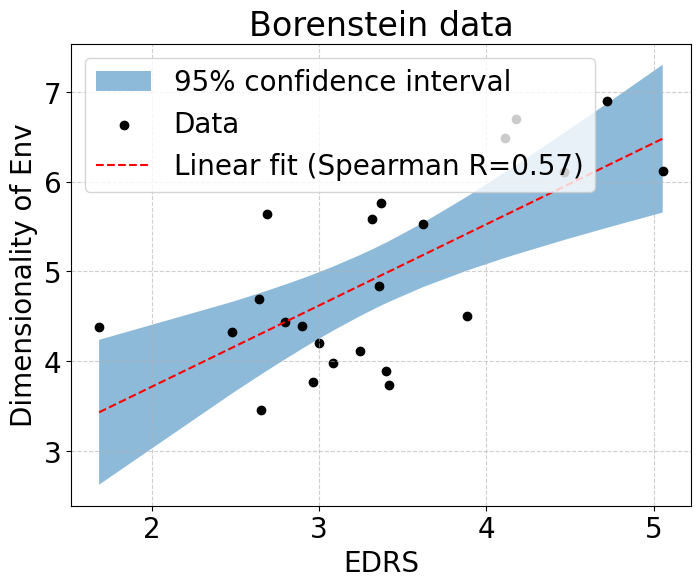

In [12]:
x = cg_all
y = svd_all

x = x[mask]
y = y[mask]

x_label = 'EDRS'
y_label = 'Dimensionality of Env'
title = 'Borenstein data'

plot_helper(x, y, x_label=x_label, y_label=y_label, title=title)
plt.savefig('Pictures_for_paper/Borenstein_END_EnvD.pdf', format='pdf')

In [13]:
output_file = '/home/ks2823/my_CRM/Data/metabolomics/borenstein_predictability.json'
with open(output_file, 'r') as f:
    read_data = json.load(f)
print(read_data.keys())

dict_keys(['labels', 'cg_list', 'in_performance_list', 'out_performance_list'])


In [14]:
labels = np.array(read_data['labels'])
cg_list = np.array(read_data['cg_list'])
in_performance_list = np.array(read_data['in_performance_list'])
out_performance_list = np.array(read_data['out_performance_list'])

In [16]:
mask = np.isin(labels, cross_sectional_labels)

Spearman R: -0.755, P‑value: 0.0004602984125426377


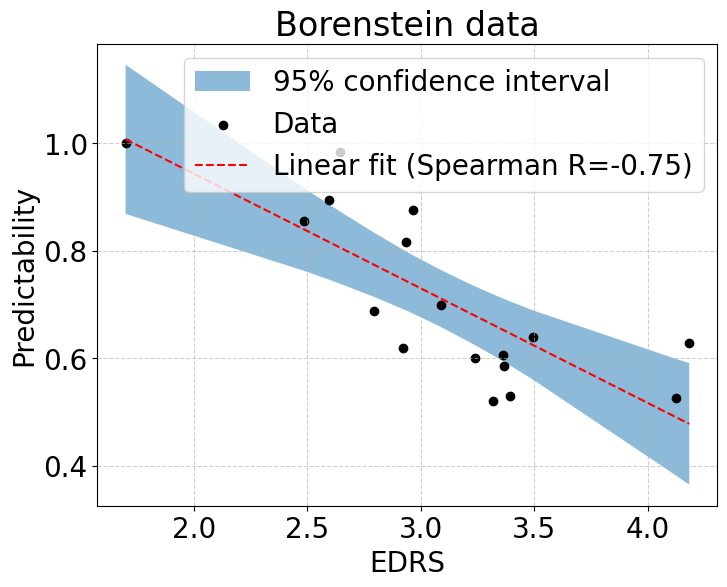

In [17]:
x = 1/cg_list
y = out_performance_list

x = x[mask]
y = y[mask]

x_label = 'EDRS'
y_label = 'Predictability'
title = 'Borenstein data'

plot_helper(x, y, x_label=x_label, y_label=y_label, title=title)
plt.savefig('Pictures_for_paper/Borenstein_END_out_pred.pdf', format='pdf')

## Microbiomap plots/ In-silico plots

In [4]:
df_5 = pd.read_csv('/home/ks2823/Microbiomap/checkpoints/in_silico_v5.csv', index_col=0)
# df_6 = pd.read_csv('/home/ks2823/Microbiomap/checkpoints/in_silico_v6.csv', index_col=0)
# df_7 = pd.read_csv('/home/ks2823/Microbiomap/checkpoints/in_silico_v7.csv', index_col=0)

df_50_bac_trade = df_5[df_5['num_niches']==1]
df_50_env_trade = df_5[np.isin(df_5['num_niches'], np.arange(2,8,1))]
# df_250_vanilla = df_7[df_7['num_niches']==1]
# df_250_env_trade = df_7[np.isin(df_7['num_niches'], np.arange(2,8,1))]
# df_250_bac_trade = df_6[df_6['num_niches']==1]
# df_250_env_bac_trade = df_6[np.isin(df_6['num_niches'], np.arange(2,8,1))]
df_microbiomap = pd.read_csv('/home/ks2823/Microbiomap/checkpoints/mb_small.csv', index_col=0)

In [4]:
df_microbiomap.columns

Index(['project', 'pr', 'se', 'pr_corrected', 'se_corrected',
       'mean_retain_null', 'Taylor_slope', 'comp', 'generalists', 'END',
       'alpha', 'beta', 'END_null', 'END_corrected', 'theta_comp',
       'theta_comp_null_s', 'theta_comp_null_r', 'theta_generalists_pr',
       'theta_generalists_pr_null', 'theta_comp_corrected',
       'theta_generalists_corrected', 'mean_load', 'var_load', 'log_mean_load',
       'log_var_load', 'mean_removed_load', 'mean_num_resources',
       'num_species'],
      dtype='object')

In [5]:
np.percentile(df_microbiomap['END_null'].dropna(), [25, 50, 75])

array([6.03947946, 7.02774772, 8.00118027])

In [3]:
np.percentile(df_250_vanilla['NicheDim'].dropna(), [25, 50, 75])

array([11.6615201 , 13.18839086, 14.85059976])

In [4]:
np.percentile(df_250_bac_trade['NicheDim'].dropna(), [25, 50, 75])

array([ 6.38638527,  9.4519179 , 13.40115295])

In [9]:
np.percentile(df_250_env_bac_trade['NicheDim'].dropna(), [25, 50, 75])

array([4.71493277, 5.77821905, 6.95355514])

In [13]:
np.percentile(df_250_env_trade['NicheDim'].dropna(), [25, 50, 75])

array([4.8781609 , 6.21648443, 8.12769083])

In [12]:
sp.stats.mannwhitneyu(df_microbiomap['END'].dropna(), df_microbiomap['END_null'].dropna())

MannwhitneyuResult(statistic=1002.0, pvalue=4.460922634672772e-49)

### Violin

In [5]:
data_50_bac_trade = df_50_bac_trade['NicheDim']
data_50_env_trade = df_50_env_trade['NicheDim']
# data_250_vanilla = df_250_vanilla['NicheDim'].dropna()
# data_250_bac_trade = df_250_bac_trade['NicheDim'].dropna()
# data_250_env_trade = df_250_env_trade['NicheDim'].dropna()
# data_250_env_bac_trade = df_250_env_bac_trade['NicheDim'].dropna()

# data_250_vanilla_null = df_250_vanilla['NicheDim_null'].dropna()
# data_250_bac_trade_null = df_250_bac_trade['NicheDim_null'].dropna()
# data_250_env_trade_null = df_250_env_trade['NicheDim_null'].dropna()
# data_250_env_bac_trade_null = df_250_env_bac_trade['NicheDim_null'].dropna()

data_microbiomap = df_microbiomap['END'].dropna()
data_microbiomap_null = df_microbiomap['END_null'].dropna()

vp_data = [
    data_microbiomap,
    # data_microbiomap_null,
    # data_250_vanilla,
    # data_250_vanilla_null,
    # data_250_bac_trade,
    # data_250_bac_trade_null,
    # data_250_env_trade,
    # data_250_env_trade_null,
    # data_250_env_bac_trade,
    # data_250_env_bac_trade_null, 
    data_50_bac_trade,
    data_50_env_trade,
]

xticklabels = [
    'Microbiomap', 
    # 'Microbiomap null',
    # '250 vanilla', 
    # '250 vanilla null',
    # '250 w tradeoffs',
    # '250 w tradeoffs null',
    # '250 w env cov',
    # '250 w env cov null',
    # '250 w tradeoffs & env cov',
    # '250 w tradeoffs & env cov null',
    '50 w tradeoffs', 
    '50 w tradeoffs & env cov', 
]

In [36]:
import itertools
pairs = itertools.combinations(vp_data, 2)
pair_keys = itertools.combinations(xticklabels, 2)

for pair, pair_keys in zip(pairs, pair_keys):
    x, y = pair
    print(pair_keys, '\n', sp.stats.mannwhitneyu(x, y))

('Microbiomap', 'Microbiomap null') 
 MannwhitneyuResult(statistic=1002.0, pvalue=4.460922634672772e-49)
('Microbiomap', '250 vanilla') 
 MannwhitneyuResult(statistic=3.0, pvalue=1.2749829874152895e-19)
('Microbiomap', '250 w tradeoffs') 
 MannwhitneyuResult(statistic=982.0, pvalue=6.826219344211141e-14)
('Microbiomap', '250 w env cov') 
 MannwhitneyuResult(statistic=4409.0, pvalue=9.791475717073363e-29)
('Microbiomap', '250 w tradeoffs & env cov') 
 MannwhitneyuResult(statistic=7307.0, pvalue=8.814698904479483e-31)
('Microbiomap null', '250 vanilla') 
 MannwhitneyuResult(statistic=198.0, pvalue=3.632937162761975e-17)
('Microbiomap null', '250 w tradeoffs') 
 MannwhitneyuResult(statistic=2237.0, pvalue=5.661642518987458e-05)
('Microbiomap null', '250 w env cov') 
 MannwhitneyuResult(statistic=17186.0, pvalue=0.003550738523268509)
('Microbiomap null', '250 w tradeoffs & env cov') 
 MannwhitneyuResult(statistic=29892.0, pvalue=1.987187147322671e-11)
('250 vanilla', '250 w tradeoffs') 
 M

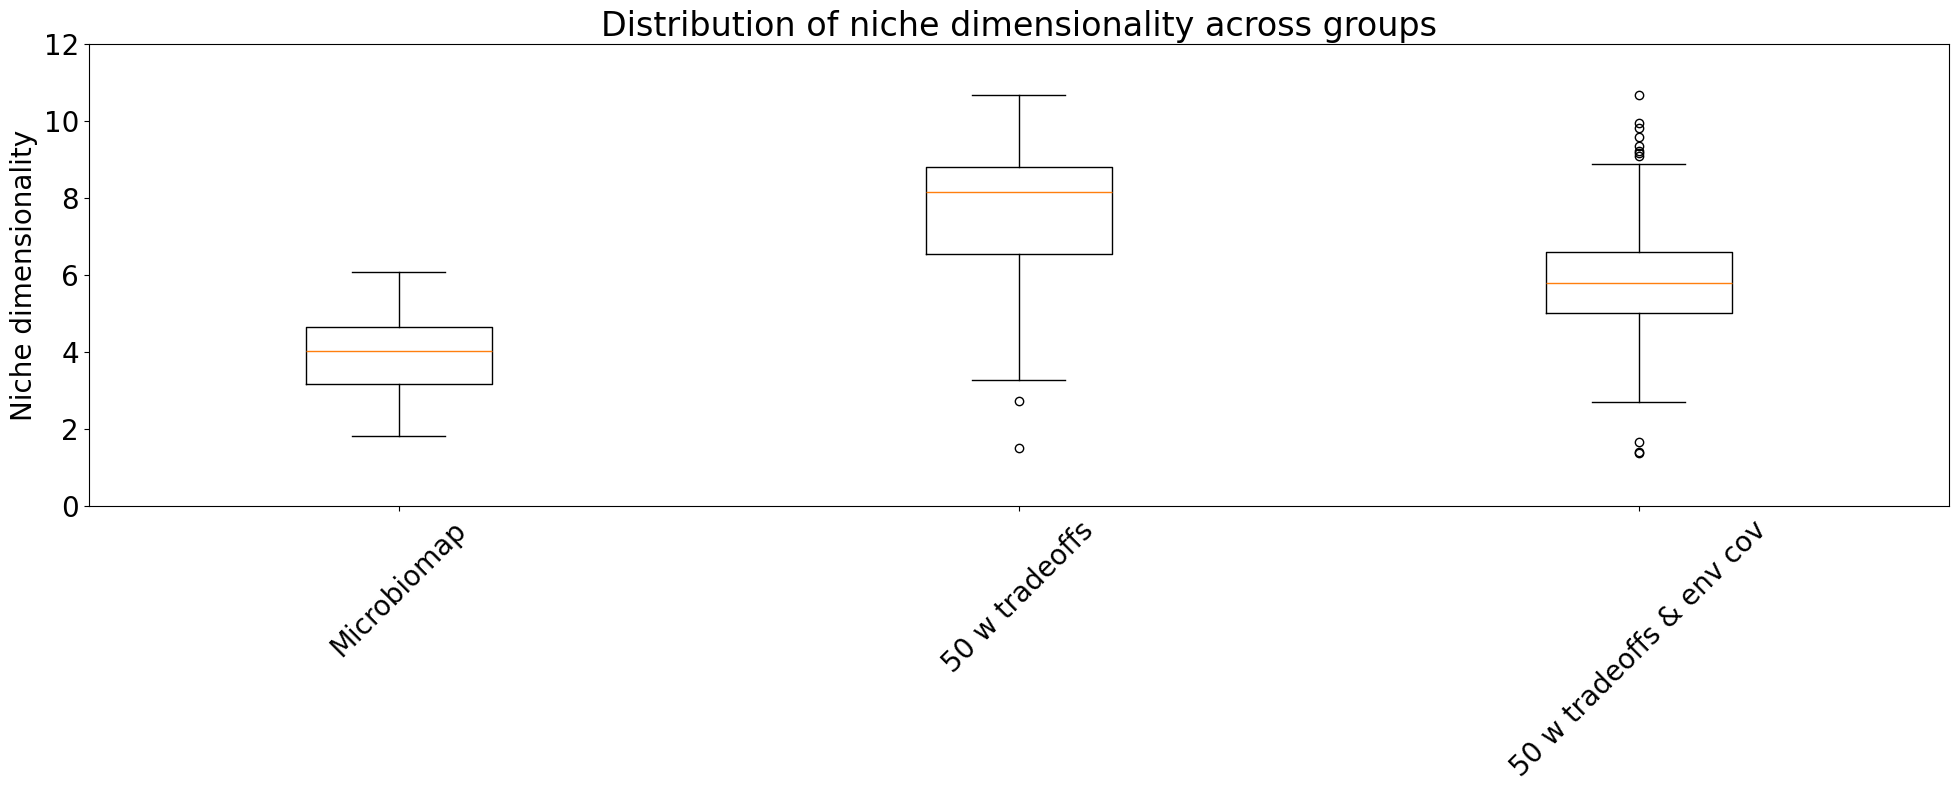

In [8]:
fig, ax = plt.subplots(figsize=(24, 6))
ax.boxplot(vp_data, positions=np.arange(len(vp_data)))
ax.set_xticks(np.arange(len(xticklabels)))
ax.set_xticklabels(xticklabels, rotation=45)
plt.title('Distribution of niche dimensionality across groups')
plt.ylabel('Niche dimensionality')
plt.ylim([0, 12])
plt.savefig('Pictures/50_niche_dim_distribution_across_groups.pdf', format='pdf')
plt.show()

### Contour

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

def plot_contour(data, levels=None, color='black', label=None, marker='x'):
    """
    Finds the optimal bandwidth via GridSearchCV and plots the KDE contour.
    """
    
    # --- 1. Standardize the Data ---
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    data_z = (data - mean[np.newaxis, :]) / std[np.newaxis, :]

    # --- 2. Use GridSearchCV to find the best bandwidth ---
    # Define a range of bandwidths to test (logarithmically spaced)
    # This searches from 0.01 (10^-2) to ~5.0 (10^0.7)
    param_grid = {'bandwidth': np.logspace(-2, 0.7, 100)}
    
    # Set up the grid search with 5-fold cross-validation
    grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                        param_grid=param_grid,
                        cv=5)
    
    # Fit the grid search to the standardized data
    grid.fit(data_z)
    
    # Get the best KDE model (this is already fit on the data)
    kde = grid.best_estimator_
    print(f"Best bandwidth found by GridSearchCV: {kde.bandwidth_:.4f}")

    
    # --- 3. Create a grid in the ORIGINAL data space ---
    # --- 3. Create an extended grid in the ORIGINAL data space ---
    x_orig = data[:, 0]
    y_orig = data[:, 1]

    # Calculate padding as 20% of the data's range
    x_range = x_orig.max() - x_orig.min()
    y_range = y_orig.max() - y_orig.min()
    x_pad = x_range * 0.20  # You can adjust this 0.20 (20%)
    y_pad = y_range * 0.20  # You can adjust this 0.20 (20%)

    # Create the new, wider grid
    x_grid_orig = np.linspace(x_orig.min() - x_pad, x_orig.max() + x_pad, 100)
    y_grid_orig = np.linspace(y_orig.min() - y_pad, y_orig.max() + y_pad, 100)

    X_orig, Y_orig = np.meshgrid(x_grid_orig, y_grid_orig)
    
    # Stack the grid points into a [N, 2] array
    xy_orig = np.vstack([X_orig.ravel(), Y_orig.ravel()]).T
    
    # --- 4. Standardize this grid for scoring ---
    # We must use the same mean/std from the training data
    xy_orig_z = (xy_orig - mean[np.newaxis, :]) / std[np.newaxis, :]

    # --- 5. Calculate density (Z) ---
    # Get the log-likelihood and exponentiate to get density
    Z = np.exp(kde.score_samples(xy_orig_z)).reshape(X_orig.shape)
    
    # Determine contour levels if not provided
    if levels is None:
        max_level = np.max(Z)
        levels = np.array([0.75, 0.85, 0.95]) * max_level
    
    # --- 6. Plot the contour and original data ---
    contour = plt.contour(X_orig, Y_orig, Z, levels=levels, colors=color)
        
    # Plot original data points for reference
    plt.scatter(x_orig, y_orig, s=30, color=color, label=label, alpha=0.25, marker=marker)
    plt.xlabel('X')
    plt.ylabel('Y')

In [10]:
output_file = '/home/ks2823/Microbiomap/Data/Borenstein_all_env.json'
with open(output_file, 'r') as f:
    read_data = json.load(f)

cg_all = np.array(read_data['NicheDim'])
svd_all = np.array(read_data['EnvDim'])
labels = np.array(read_data['label'])

cross_sectional_labels = [
    'ERAWIJANTARI_GASTRIC_CANCER_2020_Gastrectomy',
    'ERAWIJANTARI_GASTRIC_CANCER_2020_Healthy', 
    'FRANZOSA_IBD_2019_CD',
    'FRANZOSA_IBD_2019_Control', 
    'FRANZOSA_IBD_2019_UC',
    # 'HE_INFANTS_MFGM_2019_Baseline', 
    # 'HE_INFANTS_MFGM_2019_Month12',
    # 'HE_INFANTS_MFGM_2019_With.comp.food',
    # 'HE_INFANTS_MFGM_2019_Without.comp.food',
    'JACOBS_IBD_FAMILIES_2016_CD', 
    'JACOBS_IBD_FAMILIES_2016_Normal',
    'JACOBS_IBD_FAMILIES_2016_UC', 
    'KANG_AUTISM_2017_Autistic ',
    'KANG_AUTISM_2017_Neurotypical', 
    'KIM_ADENOMAS_2020_Adenoma',
    'KIM_ADENOMAS_2020_Carcinoma', 
    'KIM_ADENOMAS_2020_Control',
    'SINHA_CRC_2016_0', 
    'SINHA_CRC_2016_1', 
    'WANG_ESRD_2020_Control',
    'WANG_ESRD_2020_ESRD', 
    'YACHIDA_CRC_2019_HS',
    'YACHIDA_CRC_2019_Healthy', 
    'YACHIDA_CRC_2019_MP',
    'YACHIDA_CRC_2019_Stage_0', 
    'YACHIDA_CRC_2019_Stage_III_IV',
    'YACHIDA_CRC_2019_Stage_I_II',
]

mask = np.isin(labels, cross_sectional_labels)

x = cg_all
y = svd_all

x = x[mask]
y = y[mask]

In [11]:
data_50_env_trade = df_50_env_trade[['EnvDimLog', 'NicheDim']].dropna().values
data_50_bac_trade = df_50_bac_trade[['EnvDimLog', 'NicheDim']].dropna().values
# data_250_bac_trade = df_250_bac_trade[['EnvDimLog', 'NicheDim']].dropna().values
# data_250_vanilla = df_250_vanilla[['EnvDimLog', 'NicheDim']].dropna().values
# data_250_env_trade = df_250_env_trade[['EnvDimLog', 'NicheDim']].dropna().values
# data_250_env_bac_trade = df_250_env_bac_trade[['EnvDimLog', 'NicheDim']].dropna().values

Best bandwidth found by GridSearchCV: 0.5565
Best bandwidth found by GridSearchCV: 0.6310


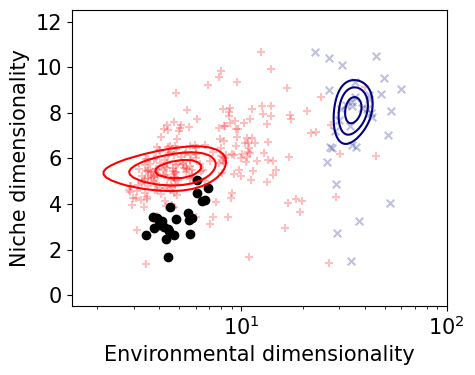

In [12]:
plt.figure(figsize=(5, 4))
plt.rcParams.update({'font.size':15})

plot_contour(data_50_env_trade, color='red', label='50 w env cov', marker='+')
plot_contour(data_50_bac_trade, color='navy', label='50 w/o env cov', marker='x')
# # plot_contour(data_250_bac_trade, color='darkorange', label='250 w tradeoffs', marker='x')
# # plot_contour(data_250_env_trade, color='green', label='250 w env cov', marker='+')
# # plot_contour(data_250_vanilla, color='mediumorchid', label='250', marker='x')
# plot_contour(data_250_env_bac_trade, color='slateblue', label='250 w tradeoffs & env cov', marker='+')
plt.scatter(y, x, label='Borenstein', color='black', marker='o')

# plt.ylim([0, 25])
plt.xlim([1.5, 100])
plt.ylabel('Niche dimensionality')
plt.xlabel('Environmental dimensionality')
plt.xscale('log')
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.title('In-silico')
plt.tight_layout()

plt.savefig('Pictures_for_paper/50_niche_dim_vs_env_dim.pdf', format='pdf')
plt.show()

In [14]:
sp.stats.spearmanr(data_50_bac_trade[:, 0], data_50_bac_trade[:, 1])

SignificanceResult(statistic=0.12436974789915967, pvalue=0.47656955457622485)

In [15]:
sp.stats.spearmanr(data_50_env_trade[:, 0], data_50_env_trade[:, 1])

SignificanceResult(statistic=0.4416202097384118, pvalue=2.9720785770539993e-12)

### Scatter

Spearman R: -0.166, P‑value: 0.01203943295578977
Spearman R: -0.440, P‑value: 0.008205781039529396


/tmp/tmp.m35Pa7Iaa1/ipykernel_1350751/1615631034.py:59: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


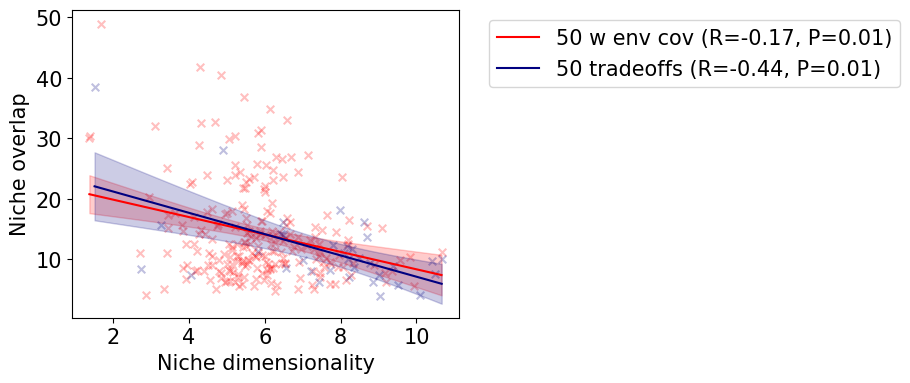

In [19]:
plt.figure(figsize=(5, 4))
x_label = 'Niche dimensionality'
y_label = 'Niche overlap'
title = 'In-silico'

x = df_50_env_trade['NicheDim']
y = df_50_env_trade['comp']
label = '50 w env cov'
color = 'red'
fill_color=color
linecolor=color
plot_helper(x, y, x_label=x_label, y_label=y_label, title=title, label=label, color=color, marker='x', linestyle='-', fill_color=fill_color, linecolor=linecolor)

x = df_50_bac_trade['NicheDim']
y = df_50_bac_trade['comp']
label = '50 tradeoffs'
color = 'navy'
fill_color=color
linecolor=color
plot_helper(x, y, x_label=x_label, y_label=y_label, title=title, label=label, color=color, marker='x', linestyle='-', fill_color=fill_color, linecolor=linecolor)

# x = df_250_bac_trade['NicheDim']
# y = df_250_bac_trade['comp']
# label = '250 tradeoffs'
# color = 'darkorange'
# fill_color=color
# linecolor=color
# print(color)
# plot_helper(x, y, x_label=x_label, y_label=y_label, title=title, label=label, color=color, marker='x', linestyle='-', fill_color=fill_color, linecolor=linecolor)

# x = df_250_vanilla['NicheDim']
# y = df_250_vanilla['comp']
# label = '250'
# color = 'mediumorchid'
# fill_color=color
# linecolor=color
# print(color)
# plot_helper(x, y, x_label=x_label, y_label=y_label, title=title, label=label, color=color, marker='x', fill_color=fill_color, linecolor=linecolor)

# x = df_250_env_trade['NicheDim']
# y = df_250_env_trade['comp']
# label = '250 w env cov'
# color = 'green'
# fill_color=color
# linecolor=color
# print(color)
# plot_helper(x, y, x_label=x_label, y_label=y_label, title=title, label=label, color=color, marker='+', fill_color=fill_color, linecolor=linecolor)

# x = df_250_env_bac_trade['NicheDim']
# y = df_250_env_bac_trade['comp']
# label = '250 w T & env cov'
# color = 'slateblue'
# fill_color=color
# linecolor=color
# print(color)
# plot_helper(x, y, x_label=x_label, y_label=y_label, title=title, label=label, color=color, marker='+', linestyle='-', fill_color=fill_color, linecolor=linecolor)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
# plt.yscale('log')
# plt.savefig('Pictures_for_paper/50_NicheDim_overlap.pdf', format='pdf')
plt.show()

Spearman R: 0.464, P‑value: 1.5287648692024392e-13
Spearman R: 0.889, P‑value: 1.0531986740655642e-12


/tmp/tmp.m35Pa7Iaa1/ipykernel_1350751/2649022195.py:59: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


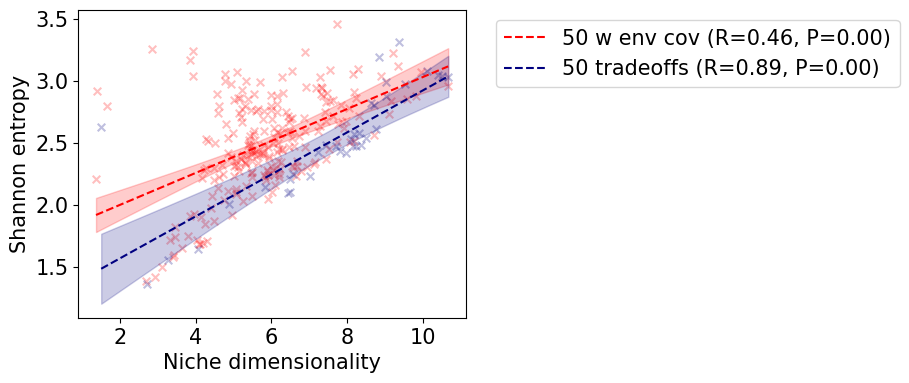

In [22]:
plt.figure(figsize=(5, 4))
x_label = 'Niche dimensionality'
y_label = 'Shannon entropy'
title = 'In-silico'

x = df_50_env_trade['NicheDim']
y = df_50_env_trade['alpha']
label = '50 w env cov'
color = 'red'
fill_color=color
linecolor=color
plot_helper(x, y, x_label=x_label, y_label=y_label, title=title, label=label, color=color, marker='x', fill_color=fill_color, linecolor=linecolor)

x = df_50_bac_trade['NicheDim']
y = df_50_bac_trade['alpha']
label = '50 tradeoffs'
color = 'navy'
fill_color=color
linecolor=color
plot_helper(x, y, x_label=x_label, y_label=y_label, title=title, label=label, color=color, marker='x', fill_color=fill_color, linecolor=linecolor)

# x = df_250_bac_trade['NicheDim']
# y = df_250_bac_trade['alpha']
# label = '250 tradeoffs'
# color = 'darkorange'
# fill_color=color
# linecolor=color
# print(color)
# plot_helper(x, y, x_label=x_label, y_label=y_label, title=title, label=label, color=color, marker='x', fill_color=fill_color, linecolor=linecolor)

# x = df_250_vanilla['NicheDim']
# y = df_250_vanilla['alpha']
# label = '250'
# color = 'mediumorchid'
# fill_color=color
# linecolor=color
# print(color)
# plot_helper(x, y, x_label=x_label, y_label=y_label, title=title, label=label, color=color, marker='x', fill_color=fill_color, linecolor=linecolor)

# x = df_250_env_trade['NicheDim']
# y = df_250_env_trade['alpha']
# label = '250 w env cov'
# color = 'green'
# fill_color=color
# linecolor=color
# print(color)
# plot_helper(x, y, x_label=x_label, y_label=y_label, title=title, label=label, color=color, marker='+', linestyle='-', fill_color=fill_color, linecolor=linecolor)

# x = df_250_env_bac_trade['NicheDim']
# y = df_250_env_bac_trade['alpha']
# label = '250 w env/bac cov'
# color = 'slateblue'
# fill_color=color
# linecolor=color
# print(color)
# plot_helper(x, y, x_label=x_label, y_label=y_label, title=title, label=label, color=color, marker='+', linestyle='-', fill_color=fill_color, linecolor=linecolor)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
# plt.savefig('Pictures_for_paper/50_NicheDim_ShannonEntropy.pdf', format='pdf')
plt.show()

### Data processing

In [ ]:
def normalize_data(data):
    data /= data.sum(axis=1)[:, np.newaxis]
    data_mean = data.mean(axis=0)
    data = data[:, data_mean>1e-3]
    data /= data.sum(axis=1)[:, np.newaxis]
    return data

def get_alpha(project):
    alpha_list = []
    for i in range(10):        
        data_path = f'/home/ks2823/Microbiomap/data_subsampled/{project}/{project}_{i}.csv'
        data = pd.read_csv(data_path, index_col=0).values
        
        for i in range(10):
            subsample_idxs = np.random.choice(data.shape[0], size=100, replace=False)
            data_subsampled = data[subsample_idxs, :]
            data_subsampled = normalize_data(data_subsampled)
            
            alpha = sp.stats.entropy(data_subsampled, axis=1)            
            alpha_list.append(alpha)

    return np.mean(alpha_list)

def get_beta(project):
    beta_list = []
    for i in range(10):        
        data_path = f'/home/ks2823/Microbiomap/data_subsampled/{project}/{project}_{i}.csv'
        data = pd.read_csv(data_path, index_col=0).values
        
        for i in range(10):
            subsample_idxs = np.random.choice(data.shape[0], size=100, replace=False)
            data_subsampled = data[subsample_idxs, :]
            data_subsampled = normalize_data(data_subsampled)
            
            beta = pdist(data_subsampled, metric='jensenshannon')
            beta_list.append(beta)        

    return np.mean(beta_list)

In [ ]:
# checkpoint_path = '/home/ks2823/Microbiomap/checkpoints/m_df_1.csv'
# mb_df = pd.read_csv(checkpoint_path, index_col=0)
# mb_df.head()

,project,exp_cg,mean_retain_null,Taylor_slope,comp,species_count,region
0,PRJDB10485,0.287460,0.174970,1.668182,4.292184,60.3,Sub-Saharan Africa
1,PRJDB10528,0.265498,0.168350,1.496769,5.161410,77.2,Eastern and South-Eastern Asia
2,PRJDB10612,0.368279,0.196280,1.438723,3.957034,44.5,unknown
3,PRJDB11845,0.195945,0.124937,1.437620,4.690277,99.6,Eastern and South-Eastern Asia
4,PRJDB11894,0.206591,0.130038,1.569955,4.265537,81.3,Eastern and South-Eastern Asia


In [13]:
mb_df['alpha'] = Parallel(n_jobs=-1)(delayed(get_alpha)(project) for project in mb_df['project'])
mb_df['beta'] = Parallel(n_jobs=-1)(delayed(get_beta)(project) for project in mb_df['project'])


mb_df.head()

,project,exp_cg,mean_retain_null,Taylor_slope,comp,species_count,region,generalists,END,alpha,beta
0,PRJDB10485,0.287460,0.174970,1.668182,4.292184,60.3,Sub-Saharan Africa,1.113747,3.478749,2.076956,0.616207
1,PRJDB10528,0.265498,0.168350,1.496769,5.161410,77.2,Eastern and South-Eastern Asia,0.450466,3.766504,2.234347,0.543396
2,PRJDB10612,0.368279,0.196280,1.438723,3.957034,44.5,unknown,0.621642,2.715330,2.005858,0.543062
3,PRJDB11845,0.195945,0.124937,1.437620,4.690277,99.6,Eastern and South-Eastern Asia,0.488290,5.103462,2.792258,0.540843
4,PRJDB11894,0.206591,0.130038,1.569955,4.265537,81.3,Eastern and South-Eastern Asia,0.630050,4.840477,2.585876,0.591862


In [14]:
generalists_df = pd.read_json('/home/ks2823/Microbiomap/Data/MB_100_subsampled_results/generalists_100.json', lines=True)

generalists_df = generalists_df.drop(columns=['id_iter', 'mean_num_resources', 'weighted_num_resources', 'weighted_to_mean_diff', 'cosine_similarity'])
generalists_df['label'] = generalists_df['label'].apply(lambda x: x.split('_')[0])
generalists_df = generalists_df.groupby('label').mean().reset_index()
generalists_df.head()

,label,weighted_to_mean_ratio
0,PRJDB10485,1.113747
1,PRJDB10528,0.450466
2,PRJDB10612,0.621642
3,PRJDB11845,0.488290
4,PRJDB11894,0.630050


In [15]:
mb_df['generalists'] = mb_df['project'].apply(lambda x: generalists_df[generalists_df['label'] == x]['weighted_to_mean_ratio'].item())
mb_df.head()

,project,exp_cg,mean_retain_null,Taylor_slope,comp,species_count,region,generalists,END,alpha,beta
0,PRJDB10485,0.287460,0.174970,1.668182,4.292184,60.3,Sub-Saharan Africa,1.113747,3.478749,2.076956,0.616207
1,PRJDB10528,0.265498,0.168350,1.496769,5.161410,77.2,Eastern and South-Eastern Asia,0.450466,3.766504,2.234347,0.543396
2,PRJDB10612,0.368279,0.196280,1.438723,3.957034,44.5,unknown,0.621642,2.715330,2.005858,0.543062
3,PRJDB11845,0.195945,0.124937,1.437620,4.690277,99.6,Eastern and South-Eastern Asia,0.488290,5.103462,2.792258,0.540843
4,PRJDB11894,0.206591,0.130038,1.569955,4.265537,81.3,Eastern and South-Eastern Asia,0.630050,4.840477,2.585876,0.591862


In [16]:
mb_df['END'] = mb_df['exp_cg'].apply(lambda x: 1/x)

In [9]:
checkpoint_path_2 = '/home/ks2823/Microbiomap/checkpoints/m_df_2.csv'
mb_df = pd.read_csv(checkpoint_path_2, index_col=0)
bin_pred = pd.read_json('/home/ks2823/Microbiomap/Data/subsampled_bin_pred.json', lines=True)
bin_pred['project'] = bin_pred['label'].apply(lambda x: x.split('_')[0])
bin_pred = bin_pred.drop(columns=['label', 'binary_sparsity'])
bin_pred = bin_pred.groupby('project').mean().reset_index()
bin_pred.head()

,project,binary_in_performance,binary_out_performance
0,PRJDB10485,0.590485,0.510524
1,PRJDB10527,0.709019,0.534963
2,PRJDB10528,0.565615,0.581711
3,PRJDB10612,0.609806,0.630984
4,PRJDB11845,0.738508,0.593034


In [10]:
combined_df =  pd.merge(mb_df, bin_pred, on='project', how='inner')
print(len(combined_df))
combined_df.head()

263


,project,exp_cg,mean_retain_null,Taylor_slope,comp,species_count,region,generalists,END,alpha,beta,binary_in_performance,binary_out_performance
0,PRJDB10485,0.287460,0.174970,1.668182,4.292184,60.3,Sub-Saharan Africa,1.113747,3.478749,2.076956,0.616207,0.590485,0.510524
1,PRJDB10528,0.265498,0.168350,1.496769,5.161410,77.2,Eastern and South-Eastern Asia,0.450466,3.766504,2.234347,0.543396,0.565615,0.581711
2,PRJDB10612,0.368279,0.196280,1.438723,3.957034,44.5,unknown,0.621642,2.715330,2.005858,0.543062,0.609806,0.630984
3,PRJDB11845,0.195945,0.124937,1.437620,4.690277,99.6,Eastern and South-Eastern Asia,0.488290,5.103462,2.792258,0.540843,0.738508,0.593034
4,PRJDB11894,0.206591,0.130038,1.569955,4.265537,81.3,Eastern and South-Eastern Asia,0.630050,4.840477,2.585876,0.591862,0.576150,0.539165


In [13]:
load_df = pd.read_csv('/home/ks2823/Microbiomap/checkpoints/cg_load_alpha_beta.csv', index_col=0)
load_df = load_df[['project', 'mean_load']]
combined_df =  pd.merge(combined_df, load_df, on='project', how='inner')
print(len(combined_df))
combined_df.head()

263


,project,exp_cg,mean_retain_null,Taylor_slope,comp,species_count,region,generalists,END,alpha,beta,binary_in_performance,binary_out_performance,mean_load
0,PRJDB10485,0.287460,0.174970,1.668182,4.292184,60.3,Sub-Saharan Africa,1.113747,3.478749,2.076956,0.616207,0.590485,0.510524,4.990292e+10
1,PRJDB10528,0.265498,0.168350,1.496769,5.161410,77.2,Eastern and South-Eastern Asia,0.450466,3.766504,2.234347,0.543396,0.565615,0.581711,6.107036e+10
2,PRJDB10612,0.368279,0.196280,1.438723,3.957034,44.5,unknown,0.621642,2.715330,2.005858,0.543062,0.609806,0.630984,4.918380e+10
3,PRJDB11845,0.195945,0.124937,1.437620,4.690277,99.6,Eastern and South-Eastern Asia,0.488290,5.103462,2.792258,0.540843,0.738508,0.593034,6.124416e+10
4,PRJDB11894,0.206591,0.130038,1.569955,4.265537,81.3,Eastern and South-Eastern Asia,0.630050,4.840477,2.585876,0.591862,0.576150,0.539165,5.888572e+10


In [14]:
combined_df.to_csv('/home/ks2823/Microbiomap/checkpoints/m_df_3.csv')

### Read data

In [4]:
checkpoint_path_3 = '/home/ks2823/Microbiomap/checkpoints/mb_small.csv'
mb_df = pd.read_csv(checkpoint_path_3, index_col=0)
mb_df.head()

,project,pr,se,pr_corrected,se_corrected,mean_retain_null,Taylor_slope,comp,generalists,END,...,theta_generalists_pr_null,theta_comp_corrected,theta_generalists_corrected,mean_load,var_load,log_mean_load,log_var_load,mean_removed_load,mean_num_resources,num_species
1,PRJDB10528,2.155223,1.544880,-0.081010,-0.064338,0.168350,1.496769,5.161410,0.450466,3.766504,...,1.000241,-0.000785,0.000301,6.107036e+10,1.834771e+20,24.835198,46.652636,7.826517e+09,16.246929,77
3,PRJDB11845,2.157682,1.548282,0.045151,0.008676,0.124937,1.437620,4.690277,0.488290,5.103462,...,0.999717,-0.000823,-0.000162,6.124416e+10,1.853193e+20,24.838126,46.667744,8.000314e+09,16.131800,99
4,PRJDB11894,2.302838,1.629094,0.042373,0.003314,0.130038,1.569955,4.265537,0.630050,4.840477,...,1.000041,-0.000762,-0.000125,5.888572e+10,1.208727e+20,24.798854,46.240588,5.641876e+09,15.014537,81
6,PRJDB5564,2.077820,1.479567,0.027125,-0.022202,0.109658,1.638456,4.386637,0.611650,4.313414,...,1.001329,0.000451,0.001546,5.225037e+10,5.812229e+19,24.679302,45.507466,-9.934673e+08,14.497224,74
8,PRJDB6804,2.022162,1.362445,-0.025136,-0.129745,0.118419,1.578910,4.887749,0.459962,2.615756,...,0.999756,-0.000696,-0.000083,5.993825e+10,6.110038e+19,24.816527,45.551854,6.694411e+09,16.504599,82


In [5]:
x='END'
y='comp'
covar=None

results = pg.partial_corr(mb_df, x=x, y=y, covar=covar, method='spearman')
print(f'{x} VS {y}, controlling for {covar}')
print(f'Spearman R: {results['r']['spearman']}, P-value: {results['p-val']['spearman']}')
print('\n')

x='END'
y='alpha'
covar=None

results = pg.partial_corr(mb_df, x=x, y=y, covar=covar, method='spearman')
print(f'{x} VS {y}, controlling for {covar}')
print(f'Spearman R: {results['r']['spearman']}, P-value: {results['p-val']['spearman']}')

END VS comp, controlling for None
Spearman R: -0.483693643988439, P-value: 3.100716094128992e-11


END VS alpha, controlling for None
Spearman R: 0.7319486133396776, P-value: 1.840954704827076e-29


In [8]:
x='comp'
y='END'
covar=None

results = pg.partial_corr(mb_df, x=x, y=y, covar=covar, method='spearman')
print(f'{x} VS {y}, controlling for {covar}')
print(f'Spearman R: {results['r']['spearman']:.4f}, P-value: {results['p-val']['spearman']:.3f}')
print('\n')

x='comp'
y='alpha'
covar=None

results = pg.partial_corr(mb_df, x=x, y=y, covar=covar, method='spearman')
print(f'{x} VS {y}, controlling for {covar}')
print(f'Spearman R: {results['r']['spearman']:.4f}, P-value: {results['p-val']['spearman']:.3f}')

comp VS END, controlling for None
Spearman R: -0.4837, P-value: 0.000


comp VS alpha, controlling for None
Spearman R: -0.4436, P-value: 0.000


Spearman R: -0.672, P‑value: 2.0579858687402833e-23


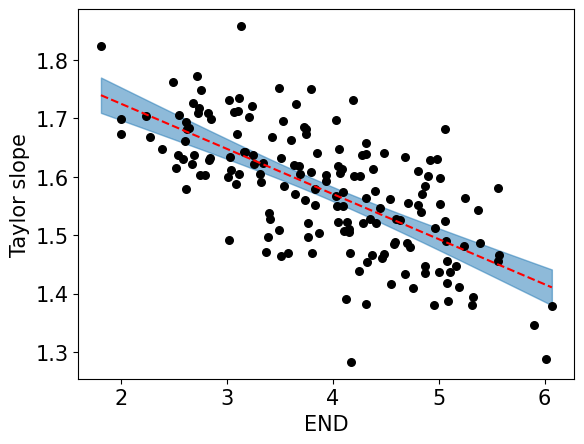

In [20]:
x = mb_df['END']
y = mb_df['Taylor_slope']

x_label = 'END'
y_label = 'Taylor slope'
title = 'Microbiomap'

# mask = (mb_df['species_count'] >10)

# x = x[mask]
# y = y[mask]

plot_helper(x, y, x_label=x_label, marker='o', scatter_alpha=1, fill_color='C0', y_label=y_label, 
            linecolor='red', fill_alpha = 0.5,title=title)
plt.savefig(f'Pictures_for_paper/MB_{x_label}_{y_label}.pdf', format='pdf')

Spearman R: 0.233, P‑value: 0.002338827905814569


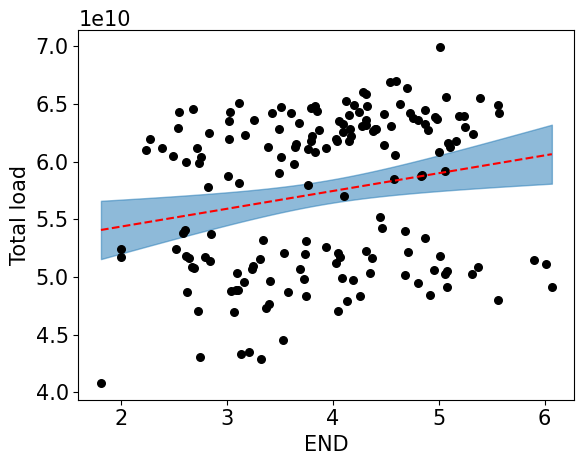

In [27]:
x = mb_df['END']
y = mb_df['mean_load']

x_label = 'END'
y_label = 'Total load'
title = 'Microbiomap'

# mask = (mb_df['species_count'] >10)

# x = x[mask]
# y = y[mask]

plot_helper(x, y, x_label=x_label, marker='o', scatter_alpha=1, fill_color='C0', y_label=y_label, 
            linecolor='red', fill_alpha = 0.5,title=title)
plt.savefig(f'Pictures_for_paper/MB_{x_label}_{y_label}.pdf', format='pdf')

Spearman R: -0.585, P‑value: 8.129028201274834e-17


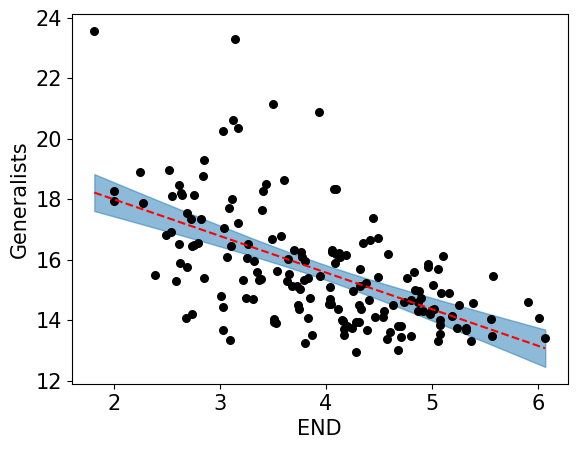

In [9]:
x = mb_df['END']
y = mb_df['mean_num_resources']

x_label = 'END'
y_label = 'Generalists'
title = 'Microbiomap'

# mask = (mb_df['species_count'] >10)

# x = x[mask]
# y = y[mask]

plot_helper(x, y, x_label=x_label, marker='o', scatter_alpha=1, fill_color='C0', y_label=y_label, 
            linecolor='red', fill_alpha = 0.5,title=title)
plt.savefig(f'Pictures_for_paper/MB_{x_label}_{y_label}.pdf', format='pdf')

Spearman R: 0.732, P‑value: 1.8409547048271942e-29


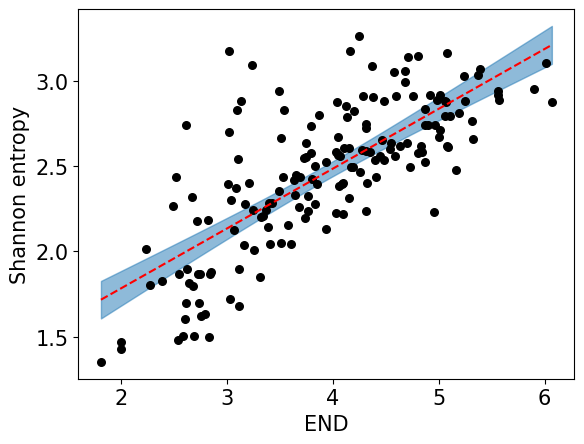

In [25]:
x = mb_df['END']
y = mb_df['alpha']

x_label = 'END'
y_label = 'Shannon entropy'
title = 'Microbiomap'

# mask = (mb_df['species_count'] >10)

# x = x[mask]
# y = y[mask]

plot_helper(x, y, x_label=x_label, marker='o', scatter_alpha=1, fill_color='C0', y_label=y_label, 
            linecolor='red', fill_alpha = 0.5,title=title)
plt.savefig('Pictures_for_paper/MB_END_Entropy.pdf', format='pdf')

Spearman R: -0.484, P‑value: 3.100716094128969e-11


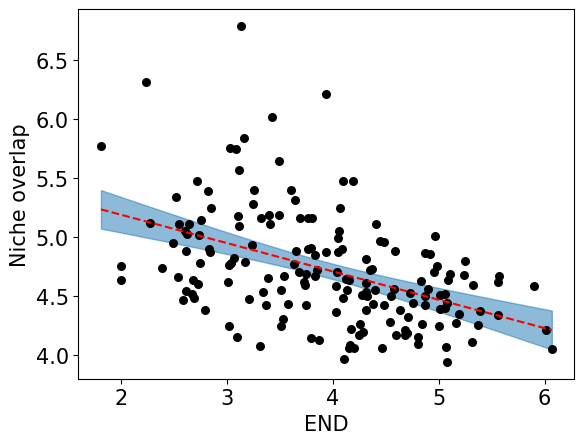

In [26]:
x = mb_df['END']
y = mb_df['comp']

x_label = 'END'
y_label = 'Niche overlap'
title = 'Microbiomap'

# mask = (mb_df['species_count'] >10)

# x = x[mask]
# y = y[mask]

plot_helper(x, y, x_label=x_label, marker='o', scatter_alpha=1, fill_color='C0', y_label=y_label, 
            linecolor='red', fill_alpha = 0.5,title=title)
plt.savefig('Pictures_for_paper/MB_END_comp.pdf', format='pdf')

In [6]:
mb_df.columns

Index(['project', 'pr', 'se', 'pr_corrected', 'se_corrected',
       'mean_retain_null', 'Taylor_slope', 'comp', 'generalists', 'END',
       'alpha', 'beta', 'END_null', 'END_corrected', 'theta_comp',
       'theta_comp_null_s', 'theta_comp_null_r', 'theta_generalists_pr',
       'theta_generalists_pr_null', 'theta_comp_corrected',
       'theta_generalists_corrected', 'mean_load', 'var_load', 'log_mean_load',
       'log_var_load', 'mean_removed_load', 'mean_num_resources',
       'num_species'],
      dtype='object')

Spearman R: 0.759, P‑value: 9.357472268046028e-33


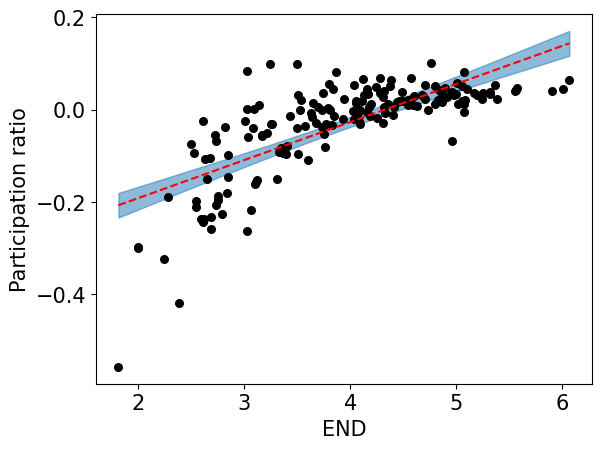

In [7]:
x = mb_df['END']
y = mb_df['pr_corrected']

x_label = 'END'
y_label = 'Participation ratio'
title = 'Microbiomap'

plot_helper(x, y, x_label=x_label, marker='o', scatter_alpha=1, fill_color='C0', y_label=y_label, 
            linecolor='red', fill_alpha = 0.5,title=title)
plt.savefig(f'Pictures_for_paper/MB_{x_label}_{y_label}.pdf', format='pdf')

Spearman R: 0.880, P‑value: 1.3028246067267902e-55


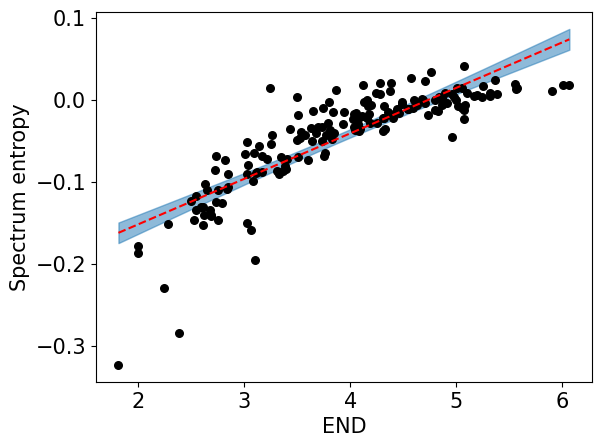

In [8]:
x = mb_df['END']
y = mb_df['se_corrected']

x_label = 'END'
y_label = 'Spectrum entropy'
title = 'Microbiomap'

plot_helper(x, y, x_label=x_label, marker='o', scatter_alpha=1, fill_color='C0', y_label=y_label, 
            linecolor='red', fill_alpha = 0.5,title=title)
plt.savefig(f'Pictures_for_paper/MB_{x_label}_{y_label}.pdf', format='pdf')

In [23]:
x='alpha'
y='generalists'
covar='END'

results = pg.partial_corr(combined_df, x=x, y=y, covar=covar, method='spearman')
print(f'{x} VS {y}, controlling for {covar}')
print(f'Spearman R: {results['r']['spearman']:.3f}, P-value: {results['p-val']['spearman']:.3f}')
print('\n')

x='alpha'
y='mean_load'
covar='END'

results = pg.partial_corr(combined_df, x=x, y=y, covar=covar, method='spearman')
print(f'{x} VS {y}, controlling for {covar}')
print(f'Spearman R: {results['r']['spearman']:.3f}, P-value: {results['p-val']['spearman']:.3f}')
# print('\n')

alpha VS generalists, controlling for END
Spearman R: 0.131, P-value: 0.034


alpha VS mean_load, controlling for END
Spearman R: 0.215, P-value: 0.000


In [17]:
x = 'alpha'
y = 'comp'
covar = 'END'

pg.partial_corr(mb_df, x=x, y=y, covar=covar)

,n,r,CI95%,p-val
pearson,263,-0.057148,"[-0.18, 0.06]",0.356864


In [ ]:
def plot_helper(x, y, x_label=None, y_label=None, title=None):
    """
    Plots a scatter plot with a linear trend line and shaded areas
    representing the confidence and prediction intervals.

    Args:
        x (array-like): The x-values for the data points.
        y (array-like): The y-values for the data points.
        x_label (str, optional): The label for the x-axis. Defaults to None.
        y_label (str, optional): The label for the y-axis. Defaults to None.
        title (str, optional): The title of the plot. Defaults to None.
    """
    plt.rcParams.update({'font.size': 20}) # Adjusted font size for better readability with intervals

    # Perform Spearman correlation
    spearman, pval = sp.stats.spearmanr(x, y)
    print(f'Spearman R: {spearman:.3f}, P-value: {pval:.3f}')

    # Perform linear regression using statsmodels for more detailed results
    # Add a constant to the independent variable (x) for the intercept
    X = sm.add_constant(x)
    model = sm.OLS(y, X)
    results = model.fit()

    # Get prediction results including confidence and prediction intervals
    predictions = results.get_prediction(X)
    summary_frame = predictions.summary_frame(alpha=0.05) # 95% intervals

    # Sort data by x-values for correct plotting of intervals with fill_between
    sorted_indices = np.argsort(x)
    x_sorted = x[sorted_indices]
    y_sorted = y[sorted_indices]
    summary_frame_sorted = summary_frame.iloc[sorted_indices]

    # Extract interval data
    mean_ci_lower = summary_frame_sorted['mean_ci_lower']
    mean_ci_upper = summary_frame_sorted['mean_ci_upper']
    predicted_mean = summary_frame_sorted['mean']

    # Plotting
    plt.figure(figsize=(8, 6))

    # Plot confidence interval (narrower, for the mean prediction)
    plt.fill_between(x_sorted, mean_ci_lower, mean_ci_upper, color='lightcoral', alpha=0.5)

    # Plot the scatter data
    plt.scatter(x_sorted, y_sorted, color='black', label='Data')

    # Plot the trend line (mean prediction)
    plt.plot(x_sorted, predicted_mean, color='red', label=f'Spearman R: {spearman:.2f}', linestyle='--')

    # Add labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6) # Add a grid for better readability

    plt.show()

Spearman R: 0.824, P-value: 0.000


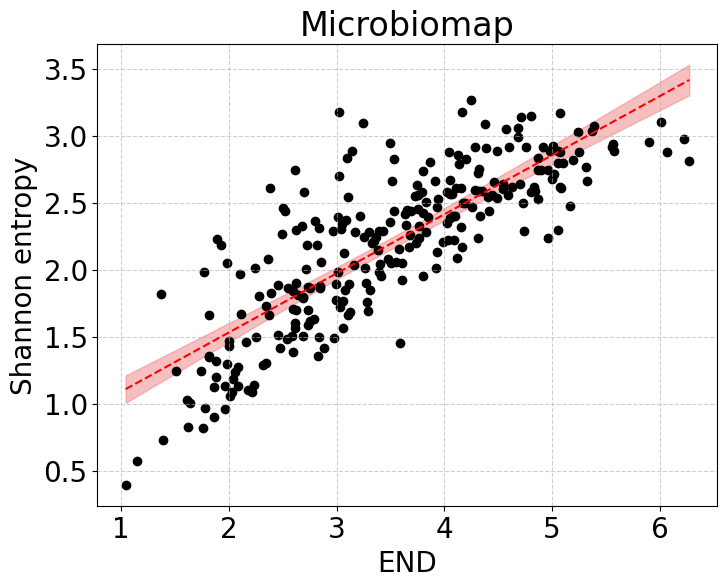

In [4]:
x = mb_df['END']
y = mb_df['alpha']

x_label = 'END'
y_label = 'Shannon entropy'
title = 'Microbiomap'

# mask = (mb_df['species_count'] >10)

# x = x[mask]
# y = y[mask]

plot_helper(x, y, x_label=x_label, y_label=y_label, title=title)
plt.savefig('Pictures_for_paper/MB_END_Entropy.pdf', format='pdf')

Spearman R: -0.399, P-value: 0.000


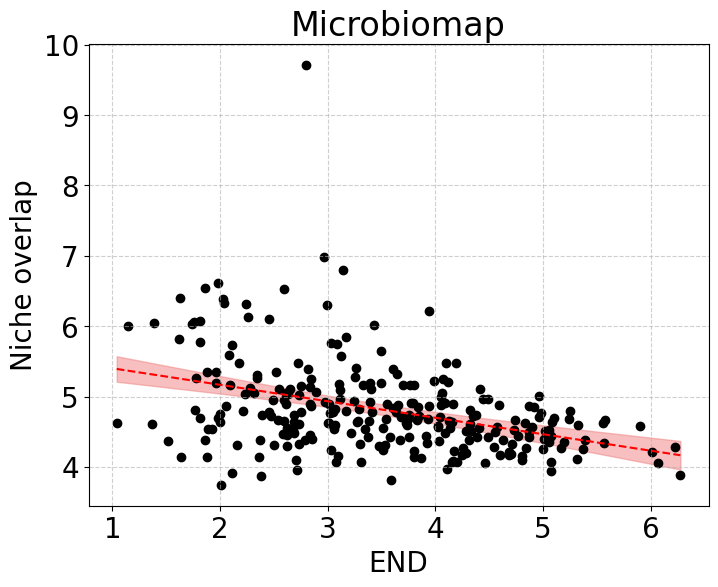

In [5]:
x = mb_df['END']
y = mb_df['comp']

x_label = 'END'
y_label = 'Niche overlap'
title = 'Microbiomap'

# mask = (mb_df['species_count'] >60)

# x = x[mask]
# y = y[mask]

plot_helper(x, y, x_label=x_label, y_label=y_label, title=title)
plt.savefig('Pictures_for_paper/MB_END_NicheOverlap.pdf', format='pdf')

Spearman R: -0.148, P-value: 0.017


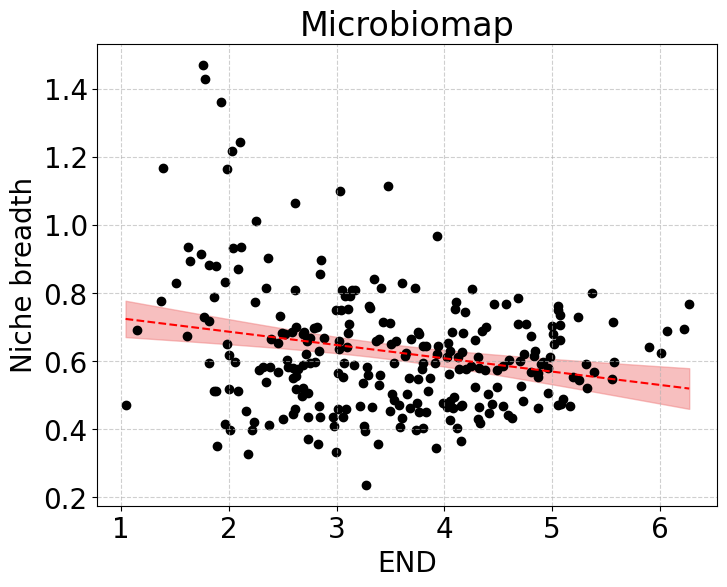

In [7]:
x = mb_df['END']
y = mb_df['generalists']

x_label = 'END'
y_label = 'Niche breadth'
title = 'Microbiomap'

# mask = (mb_df['species_count'] >40)

# x = x[mask]
# y = y[mask]

plot_helper(x, y, x_label=x_label, y_label=y_label, title=title)
plt.savefig('Pictures_for_paper/MB_END_Generalists.pdf', format='pdf')

In [8]:
x = combined_df['END']
y = combined_df['binary_out_performance']

x_label = 'END'
y_label = 'Composition to Env predictability'
title = 'Microbiomap'

plot_helper(x, y, x_label=x_label, y_label=y_label, title=title)
plt.savefig('Pictures_for_paper/MB_END_Bin_pred_out.pdf', format='pdf')

NameError: name 'combined_df' is not defined

### Borenstein data

In [ ]:
# def calc_cg_pred(entry, eta, num_steps, num_iterations=10):
#     data, target = np.array(entry['data']), np.array(entry['mtb'])

#     num_sub_sample = min(int(0.7 * data.shape[0]), 50)

#     # Ensure unique subsamples by storing as tuples in a set
#     sub_sample_idxs = set()
#     while len(sub_sample_idxs) < num_iterations:
#         idxs = tuple(np.random.choice(data.shape[0], num_sub_sample, replace=False))
#         sub_sample_idxs.add(idxs)    

#     # print(entry['label'], data.shape, target.shape)

#     def process_sample(idxs):
#         data_sub_sampled = data[list(idxs), :]
#         target_sub_sampled = target[list(idxs), :]

#         target_sub_sampled_std = np.std(target_sub_sampled, axis=0)
#         target_sub_sampled_non_constant_idxs = np.isclose(target_sub_sampled_std, np.zeros_like(target_sub_sampled_std))

#         target_sub_sampled = target_sub_sampled[:, ~target_sub_sampled_non_constant_idxs]

#         survived_idxs = np.mean(data_sub_sampled, axis=0) > 1e-3
#         data_sub_sampled = data_sub_sampled[:, survived_idxs]
#         data_sub_sampled = data_sub_sampled / np.sum(data_sub_sampled, axis=1)[:, np.newaxis]
        
#         target_sub_sampled -= np.mean(target_sub_sampled, axis=0)[np.newaxis, :]
#         target_sub_sampled /= np.std(target_sub_sampled, axis=0)[np.newaxis, :]

#         obj = predict(data=data_sub_sampled, target=target_sub_sampled, eta=eta, num_steps=num_steps, plot_loss=False)
#         obj.train_microbiome_lasso_model(test_size=0.2, plot_performance=False, tol=1e-4)
#         obj.cg_score()

#         # Collect results
#         cg = obj.cg[0]
#         # cg_null = None#obj.cg_null

#         in_performance = obj.microbiome_r2_train
#         out_performance = obj.microbiome_r2_test

#         top_in_performance = in_performance[np.argsort(in_performance)[::-1][:int(0.1*in_performance.shape[0])]]
#         top_out_performance = out_performance[np.argsort(out_performance)[::-1][:int(0.1*out_performance.shape[0])]]

#         top_in_performance = np.mean(top_in_performance)
#         top_out_performance = np.mean(top_out_performance)

#         return cg, top_in_performance, top_out_performance
    
#     results = Parallel(n_jobs=-1)(delayed(process_sample)(idxs) for idxs in sub_sample_idxs)
    
#     cg_list, in_performance_list, out_performance_list = zip(*results)

#     mean_cg = np.mean(cg_list)
#     mean_in_performance = np.nanmean(in_performance_list)
#     mean_out_performance = np.nanmean(out_performance_list)
    
#     return mean_cg, mean_in_performance, mean_out_performance

# # Parameters
# num_cores = -1  # Use all available cores
# eta = 0.01
# num_steps = 30000

# # Load JSON file
# with open("/home/ks2823/my_CRM/Data/metabolomics/borenstein.json", "r") as f:
#     data_list = json.load(f)

# # Convert lists back into NumPy arrays
# for entry in data_list:
#     entry['data'] = np.array(entry['data'])
#     entry['mtb'] = np.array(entry['mtb'])

# labels=[]
# results = []
# for entry in tqdm(data_list):
#     labels.append(entry['label'])
#     if ~np.isin(entry['label'].split('_')[0], ['KIM', 'SINHA']): 
#         met = entry['mtb']
#         percent_nonzero = np.count_nonzero(met, axis=0)/met.shape[0]
#         high_abu_cols = percent_nonzero == 1

#         met = met[:, high_abu_cols]

#         assert np.all(met >= 0), f'{entry['label']} contains negative values {met[met<0]}'
#         entry['mtb'] = np.log(met + 0.1*np.min(met[met>0]))

#     # Use Parallel and delayed to process entries in parallel
#     results.append(calc_cg_pred(entry, eta, num_steps, num_iterations=100))

# # Unpack results
# cg_list, in_performance_list, out_performance_list = zip(*results)

# # If you need to convert the lists back to lists (they will be tuples)
# cg_list = np.array(cg_list)
# in_performance_list = np.array(in_performance_list)
# out_performance_list = np.array(out_performance_list)

100%|██████████| 16/16 [05:36<00:00, 21.04s/it]


In [ ]:
# # Convert NumPy arrays to Python lists so they can be serialized to JSON
# cg_list_python = cg_list.tolist()
# in_performance_list_python = in_performance_list.tolist()
# out_performance_list_python = out_performance_list.tolist()

# # Create a dictionary to hold the lists
# data_dictionary = {
#     'cg_list': cg_list_python,
#     'in_performance_list': in_performance_list_python,
#     'out_performance_list': out_performance_list_python
# }

# # Define the filename for the JSON file
# json_file = 'Data/Borenstein_predictability.json'

# # Save the dictionary to a JSON file
# with open(json_file, 'w') as f:
#     json.dump(data_dictionary, f)

# print(f"Saved the data dictionary to: {json_file}")

Saved the data dictionary to: Data/Borenstein_predictability.json


In [2]:
# Define the filename
json_file = 'Data/Borenstein_predictability.json'

# Load the data from the JSON file
with open(json_file, 'r') as f:
    loaded_data = json.load(f)

# Access the loaded lists
cg_list = np.array(loaded_data['cg_list'])
in_performance_list = np.array(loaded_data['in_performance_list'])
out_performance_list = np.array(loaded_data['out_performance_list'])

print("Loaded the data dictionary back successfully!")
print(f"Shape of loaded cg_list: {cg_list.shape}")

Loaded the data dictionary back successfully!
Shape of loaded cg_list: (16,)


Spearman R: -0.532, P-value: 0.034


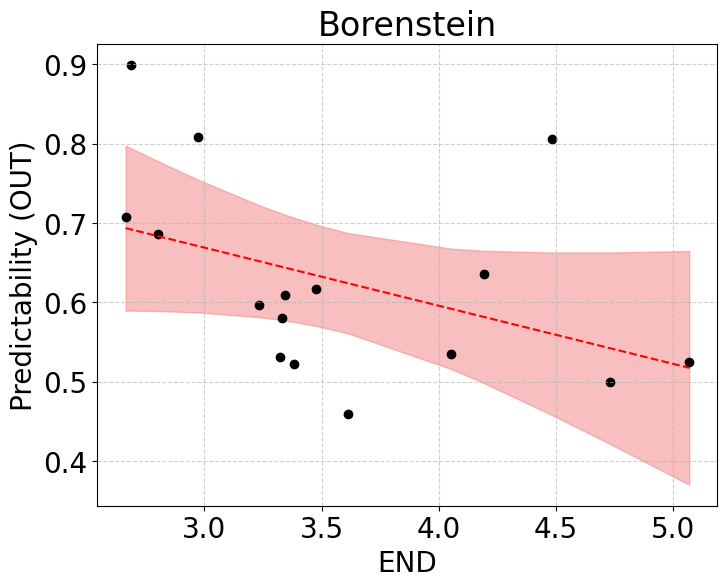

In [7]:
x = 1/np.array(cg_list)
y = np.array(out_performance_list)

x_label = 'END'
y_label = 'Predictability (OUT)'
title = 'Borenstein'

# mask = (mb_df['species_count'] >40)

# x = x[mask]
# y = y[mask]

plot_helper(x, y, x_label=x_label, y_label=y_label, title=title)
# plt.show()
plt.savefig('Pictures_for_paper/Borenstein_END_OutPred.pdf', format='pdf')


In [38]:
# Define a colormap
cmap = plt.get_cmap('tab20')  # Choose a colormap with enough distinct colors

plt.figure(figsize=(7, 6))

for i, (cg, out_performance, label) in enumerate(zip(cg_list, out_performance_list, labels)):
    # Assign a unique color from the colormap
    color = cmap(i % 20)
    plt.scatter(1/cg, out_performance, color='black', edgecolors='black', s=80)#, label=f'{label}'
    # Add label directly next to the point
    annotation = "_".join([label.split('_')[0][0], "_".join(label.split('_')[3:])])

    # plt.text(1/cg, out_performance, annotation, fontsize=12, ha='left', va='bottom', color=color)

mask = ~np.isnan(out_performance_list)
edrs_masked = np.array(cg_list)[mask]
out_perf_masked = np.array(out_performance_list)[mask]
spearman, pval = sp.stats.spearmanr(1/edrs_masked, out_perf_masked)
print(f'R: {spearman:.2f}, P-value: {pval:.3f}, label: All')

# Fit a straight line to all data points
x = 1/edrs_masked
y = out_perf_masked
slope, intercept, _, _, std_err = sp.stats.linregress(x, y)

# Create the line data
line_x = np.linspace(min(x), max(x), 100)
line_y = slope * line_x + intercept

# Plot the line
plt.plot(line_x, line_y, color='red', label=f'R: {spearman:.2f}', linestyle='--')

plt.legend()# plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('END')
plt.ylabel('Predictability (OUT)')
plt.title('Borenstein')
# plt.xlim([2.5, 5.5])
plt.tight_layout()
# plt.show()
plt.savefig('Pictures_for_paper/Borenstein_END_OutPred.pdf', format='pdf')


NameError: name 'labels' is not defined

<Figure size 700x600 with 0 Axes>

## Figure 4

In [ ]:
import seaborn as sns
from itertools import combinations

def plot_violin_and_ks(df, title, y_label=None):
    # Convert wide format to long format
    df_long = df.melt(var_name="Group", value_name="Value")

    # Create the violin plot with the correct `hue`
    plt.figure(figsize=(8, 5))
    sns.violinplot(x="Group", y="Value", hue="Group", data=df_long, inner="box", palette="pastel", legend=False)

    # Labels and title
    plt.xlabel("Group")
    plt.ylabel(y_label)
    plt.title(title)
    
    # Rotate x-axis labels if needed
    plt.xticks(rotation=45)
    
    # Show plot
    plt.show()

    # Perform KS 2-sample test for all pairs of groups
    unique_groups = df.columns.tolist()
    print(f"\nKS 2-sample test results for {title}:")
    
    for group in unique_groups:
        print(f"Mean value of {group}: {df[group].mean()}")
    
    for g1, g2 in combinations(unique_groups, 2):
        ks_stat, p_value = ks_2samp(df[g1], df[g2])
        print(f"KS Test between {g1} and {g2}: KS Statistic = {ks_stat:.4f}, p-value = {p_value:.4g}")
    
    # plt.savefig(f'Pictures_for_paper/Embedding_error_{title}.pdf', format='pdf')

In [3]:
borenstein_embedding_error_files = glob.glob('Data/Borenstein_embedding_error/*')
for data_file in borenstein_embedding_error_files:
    title = data_file.split('/')[-1].split('.')[0]
    df = pd.read_csv(data_file, index_col=0)
    print(df)
    # plot_violin_and_ks(df, title=title)

           CD   Control        UC
0    0.200858  0.190524  0.215981
1    0.194880  0.198587  0.215541
2    0.199292  0.190404  0.216713
3    0.196445  0.192884  0.212862
4    0.201302  0.189682  0.220189
..        ...       ...       ...
495  0.203278  0.197556  0.217823
496  0.207187  0.185803  0.209097
497  0.198451  0.188270  0.219521
498  0.192566  0.186614  0.219177
499  0.199182  0.186249  0.216044

[500 rows x 3 columns]
      Adenoma   Control
0    0.190453  0.177436
1    0.186844  0.176087
2    0.187215  0.170075
3    0.187914  0.182984
4    0.185564  0.183035
..        ...       ...
495  0.191636  0.171271
496  0.188562  0.175173
497  0.184318  0.179649
498  0.188663  0.176306
499  0.191936  0.172026

[500 rows x 2 columns]
      Control      ESRD
0    0.133472  0.158283
1    0.128172  0.156924
2    0.133239  0.153624
3    0.131252  0.155009
4    0.126803  0.163071
..        ...       ...
495  0.128854  0.161847
496  0.127660  0.156627
497  0.132857  0.158336
498  0.131467  0